# UKBB MVP Finngen summary statistics preparation

## Setup

In [68]:
from pyspark.sql import Column, DataFrame
from pyspark.sql import functions as f

from gentropy import Session


In [92]:
session = Session(
    spark_uri="yarn",
    extended_spark_conf={
        "spark.master.memory": "16G",
        "spark.driver.maxResultSize": "10G",
    },
    use_enhanced_bgzip_codec=True,
    write_mode="overwrite",
)

25/10/06 21:18:37 WARN SparkConf: The configuration key 'spark.yarn.executor.failuresValidityInterval' has been deprecated as of Spark 3.5 and may be removed in the future. Please use the new key 'spark.executor.failuresValidityInterval' instead.
25/10/06 21:18:37 WARN SparkConf: The configuration key 'spark.yarn.executor.failuresValidityInterval' has been deprecated as of Spark 3.5 and may be removed in the future. Please use the new key 'spark.executor.failuresValidityInterval' instead.
25/10/06 21:18:37 WARN SparkConf: The configuration key 'spark.yarn.executor.failuresValidityInterval' has been deprecated as of Spark 3.5 and may be removed in the future. Please use the new key 'spark.executor.failuresValidityInterval' instead.
25/10/06 21:18:37 WARN SparkConf: The configuration key 'spark.yarn.executor.failuresValidityInterval' has been deprecated as of Spark 3.5 and may be removed in the future. Please use the new key 'spark.executor.failuresValidityInterval' instead.
25/10/06 21:

In [3]:
## Inputs
source_manifest_path = "gs://finngen-public-data-r12/meta_analysis/mvp_ukbb/FinnGen_R12_MVP_UKBB_manifest.tsv"
source_summary_statistics_glob = (
    "gs://finngen-public-data-r12/meta_analysis/mvp_ukbb/summary_stats/*.gz"
)
efo_curation_path = "https://raw.githubusercontent.com/opentargets/curation/refs/tags/25.09/mappings/disease/manual_string.tsv"
gnomad_variant_index_path = "gs://gnomad_data_2/v4.1/variant_index/"

## Outputs
study_index_output_path = "gs://finngen_ukb_mvp_meta_data/study_index/"
raw_summary_statistics_output_path = (
    "gs://finngen_ukb_mvp_meta_data/raw_summary_statistics/"
)
harmonised_summary_statistics_output_path = (
    "gs://finngen_ukb_mvp_meta_data/harmonised_summary_statistics/"
)


### Building StudyIndex

In [4]:
from gentropy.finngen_ukb_mvp_meta import FinngenUkbbMvpMetaIngestionStep

In [5]:
FinngenUkbbMvpMetaIngestionStep(
    session=session,
    source_manifest_path=source_manifest_path,
    source_summary_statistics_glob=source_summary_statistics_glob,
    efo_curation_path=efo_curation_path,
    gnomad_variant_index_path=gnomad_variant_index_path,
    study_index_output_path=study_index_output_path,
    raw_summary_statistics_output_path=raw_summary_statistics_output_path,
    harmonised_summary_statistics_output_path=harmonised_summary_statistics_output_path,
)

25/10/06 17:58:16 WARN SparkConf: The configuration key 'spark.yarn.executor.failuresValidityInterval' has been deprecated as of Spark 3.5 and may be removed in the future. Please use the new key 'spark.executor.failuresValidityInterval' instead.
25/10/06 17:58:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/10/06 18:04:32 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 81 for reason Container marked as failed: container_1759739267367_0022_01_000082 on host: ot-genetics-dev-000-mindos-sw-tdgk.europe-west1-b.c.open-targets-genetics-dev.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
25/10/06 18:04:32 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 71 for reason Container marked as failed: container_1759739267367_0022_01_000072 on host: ot-genetics-dev-000

25/10/06 18:48:15 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 133 for reason Container marked as failed: container_1759739267367_0022_01_000134 on host: ot-genetics-dev-000-mindos-sw-9hv3.europe-west1-b.c.open-targets-genetics-dev.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
25/10/06 18:48:15 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 83 for reason Container marked as failed: container_1759739267367_0022_01_000084 on host: ot-genetics-dev-000-mindos-sw-1k1q.europe-west1-b.c.open-targets-genetics-dev.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.


#### Reading studyIndex

In [6]:
from gentropy import StudyIndex

si = StudyIndex.from_parquet(session, study_index_output_path)
si.df.show()

+--------------------+--------------------+---------+--------------------+------------------------+----------+------+---------------------+-----------+--------+----------------+----------------------+---------------+------------------+----------------------------------+--------------------+--------------------+------+---------+--------+--------------------+---------------------+--------------------+------------------+---------------+-------------+--------------------+-----------+---------+---------------+
|             studyId|           projectId|studyType|     traitFromSource|traitFromSourceMappedIds|diseaseIds|geneId|biosampleFromSourceId|biosampleId|pubmedId|publicationTitle|publicationFirstAuthor|publicationDate|publicationJournal|backgroundTraitFromSourceMappedIds|backgroundDiseaseIds|   initialSampleSize|nCases|nControls|nSamples|             cohorts|ldPopulationStructure|    discoverySamples|replicationSamples|qualityControls|analysisFlags|summarystatsLocation|hasSumstats|condi

#### nSamples validation

In [7]:
from gentropy.datasource.finngen_meta import FinnGenMetaManifest

finngen_manifest = FinnGenMetaManifest.from_path(session, source_manifest_path)
finngen_manifest._df.filter(f.col("fg_phenotype") == "I9_AVBLOCK").show()

+--------+----------+-------------+------------+------------+---------------+---------------+------------------+---------------+------------------+---------------+------------------+--------------------+
|    name|fg_n_cases|fg_n_controls|fg_phenotype|ukbb_n_cases|ukbb_n_controls|MVP_AMR_n_cases|MVP_AMR_n_controls|MVP_EUR_n_cases|MVP_EUR_n_controls|MVP_AFR_n_cases|MVP_AFR_n_controls|         path_bucket|
+--------+----------+-------------+------------+------------+---------------+---------------+------------------+---------------+------------------+---------------+------------------+--------------------+
|AV-block|      7850|       375343|  I9_AVBLOCK|        3088|         384657|            817|             49621|          15010|            431314|           2893|            115972|gs://finngen-publ...|
+--------+----------+-------------+------------+------------+---------------+---------------+------------------+---------------+------------------+---------------+------------------+--

#### Disease validation

In [16]:
disease_index_path = (
    "gs://open-targets-pipeline-runs/il/25.09-testrun-1/output/disease/"
)
target_index_path = "gs://open-targets-pipeline-runs/il/25.09-testrun-1/output/target/"
biosample_index_path = (
    "gs://open-targets-pipeline-runs/il/25.09-testrun-1/output/biosample/"
)
invalid_qc_reasons = [
    "UNRESOLVED_TARGET",
    "UNRESOLVED_DISEASE",
    "UNKNOWN_STUDY_TYPE",
    "DUPLICATED_STUDY",
    "UNKNOWN_BIOSAMPLE",
    "FAILED_MEAN_BETA_CHECK",
    "FAILED_PZ_CHECK",
    "FAILED_GC_LAMBDA_CHECK",
    "NO_OT_CURATION",
    "CASE_CASE_STUDY_DESIGN",
]
valid_study_index_path = "gs://finngen_ukb_mvp_meta_data/valid_study_index/"
invalid_study_index_path = "gs://finngen_ukb_mvp_meta_data/invalid_study_index/"


In [9]:
disease_index = (
    session.spark.read.parquet(disease_index_path)
    .select(
        f.col("id").alias("diseaseId"),
        f.explode_outer(
            f.when(
                f.col("obsoleteTerms").isNotNull(),
                f.array_union(f.array("id"), f.col("obsoleteTerms")),
            )
        ).alias("efo"),
    )
    .withColumn("efo", f.coalesce(f.col("efo"), f.col("diseaseId")))
)

In [11]:
from gentropy.study_validation import StudyValidationStep


In [17]:
StudyValidationStep(
    session,
    study_index_path=[study_index_output_path],
    target_index_path=target_index_path,
    disease_index_path=disease_index_path,
    biosample_index_path=biosample_index_path,
    invalid_qc_reasons=invalid_qc_reasons,
    valid_study_index_path=valid_study_index_path,
    invalid_study_index_path=invalid_study_index_path,
)

25/10/06 19:11:23 WARN SparkConf: The configuration key 'spark.yarn.executor.failuresValidityInterval' has been deprecated as of Spark 3.5 and may be removed in the future. Please use the new key 'spark.executor.failuresValidityInterval' instead.
25/10/06 19:11:25 WARN SparkConf: The configuration key 'spark.yarn.executor.failuresValidityInterval' has been deprecated as of Spark 3.5 and may be removed in the future. Please use the new key 'spark.executor.failuresValidityInterval' instead.
25/10/06 19:11:26 WARN SparkConf: The configuration key 'spark.yarn.executor.failuresValidityInterval' has been deprecated as of Spark 3.5 and may be removed in the future. Please use the new key 'spark.executor.failuresValidityInterval' instead.
25/10/06 19:11:30 WARN SparkConf: The configuration key 'spark.yarn.executor.failuresValidityInterval' has been deprecated as of Spark 3.5 and may be removed in the future. Please use the new key 'spark.executor.failuresValidityInterval' instead.
25/10/06 19:

In [18]:
StudyIndex.from_parquet(session, valid_study_index_path).df.count()

321

In [19]:
StudyIndex.from_parquet(session, invalid_study_index_path).df.count()

9

In [22]:
StudyIndex.from_parquet(session, invalid_study_index_path).df.select(
    "studyId", "qualityControls"
).show(truncate=False)

+-------------------------------------------------------------+-----------------------------------+
|studyId                                                      |qualityControls                    |
+-------------------------------------------------------------+-----------------------------------+
|FINNGEN_R12_UKB_MVP_META_Q17_OTHER_CONGEN_MALFO_DIGES_SYSTEM1|[No valid disease identifier found]|
|FINNGEN_R12_UKB_MVP_META_N14_HYPERTROPHYBREAST_BOTH          |[No valid disease identifier found]|
|FINNGEN_R12_UKB_MVP_META_H7_PERIPHRETINADEGEN                |[No valid disease identifier found]|
|FINNGEN_R12_UKB_MVP_META_L12_OTHPIGMENTATION                 |[No valid disease identifier found]|
|FINNGEN_R12_UKB_MVP_META_K11_PARODON_OPER                    |[No valid disease identifier found]|
|FINNGEN_R12_UKB_MVP_META_D3_ANAEMIA_FOLATEDEF                |[No valid disease identifier found]|
|FINNGEN_R12_UKB_MVP_META_M13_FINGERDEFORM                    |[No valid disease identifier found]|


### Preparing variant annotations for flipping

In [128]:
from gentropy.dataset.variant_direction import VariantDirection
from gentropy.dataset.variant_index import VariantIndex

In [129]:
vi = VariantIndex.from_parquet(session, gnomad_variant_index_path)

In [130]:
vd = VariantDirection.from_variant_index(variant_index=vi)

In [131]:
vd.df.show()

+----------+-------------------+----+-------------------+---------+------+-------------+
|chromosome|  originalVariantId|type|          variantId|direction|strand|isPalindromic|
+----------+-------------------+----+-------------------+---------+------+-------------+
|         4|     4_64274529_A_G|   1|     4_64274529_A_G|        1|     1|        false|
|         4|     4_64274529_A_G|   1|     4_64274529_G_A|       -1|     1|        false|
|         4|     4_64274529_A_G|   1|     4_64274529_T_C|        1|    -1|        false|
|         4|     4_64274529_A_G|   1|     4_64274529_C_T|       -1|    -1|        false|
|         4|     4_64274530_G_C|   1|     4_64274530_G_C|        1|     1|         true|
|         4|     4_64274530_G_C|   1|     4_64274530_C_G|       -1|     1|         true|
|         4|     4_64274530_G_C|   1|     4_64274530_C_G|        1|    -1|         true|
|         4|     4_64274530_G_C|   1|     4_64274530_G_C|       -1|    -1|         true|
|         4|     4_64

## Munge summary statistics

In [34]:
from gentropy.common.stats import pvalue_from_neglogpval

In [93]:
sst = session.spark.read.parquet(raw_summary_statistics_output_path)

In [118]:
sst.printSchema()

root
 |-- #CHR: string (nullable = true)
 |-- POS: long (nullable = true)
 |-- REF: string (nullable = true)
 |-- ALT: string (nullable = true)
 |-- SNP: string (nullable = true)
 |-- fg_beta: double (nullable = true)
 |-- fg_sebeta: double (nullable = true)
 |-- fg_pval: double (nullable = true)
 |-- fg_af_alt: double (nullable = true)
 |-- fg_af_alt_cases: double (nullable = true)
 |-- fg_af_alt_controls: double (nullable = true)
 |-- MVP_EUR_beta: double (nullable = true)
 |-- MVP_EUR_sebeta: double (nullable = true)
 |-- MVP_EUR_pval: double (nullable = true)
 |-- MVP_EUR_af_alt: double (nullable = true)
 |-- MVP_EUR_r2: double (nullable = true)
 |-- MVP_AFR_beta: double (nullable = true)
 |-- MVP_AFR_sebeta: double (nullable = true)
 |-- MVP_AFR_pval: double (nullable = true)
 |-- MVP_AFR_af_alt: double (nullable = true)
 |-- MVP_AFR_r2: double (nullable = true)
 |-- MVP_HIS_beta: double (nullable = true)
 |-- MVP_HIS_sebeta: double (nullable = true)
 |-- MVP_HIS_pval: double (nul

In [44]:
sst.select(
    f.col("studyId"),
    f.col("#CHR").alias("chromosome"),
    f.col("POS").alias("position"),
    f.col("REF").alias("referenceAllele"),
    f.col("ALT").alias("alternateAllele"),
    f.col("all_inv_var_meta_beta").alias("beta"),
    f.col("all_inv_var_meta_sebeta").alias("standardError"),
    *pvalue_from_neglogpval(f.col("all_inv_var_meta_mlogp")),
    f.col("all_meta_N"),
).filter(
    f.col("studyId") == "FINNGEN_R12_UKB_MVP_META_CD2_HODGKIN_LYMPHOMA_EXALLC"
).filter(f.col("pValueMantissa").isNull()).limit(10).show(truncate=False)

+----------------------------------------------------+----------+--------+---------------+---------------+----+-------------+--------------+--------------+----------+
|studyId                                             |chromosome|position|referenceAllele|alternateAllele|beta|standardError|pValueMantissa|pValueExponent|all_meta_N|
+----------------------------------------------------+----------+--------+---------------+---------------+----+-------------+--------------+--------------+----------+
|FINNGEN_R12_UKB_MVP_META_CD2_HODGKIN_LYMPHOMA_EXALLC|1         |778661  |T              |C              |NULL|0.0          |NULL          |NULL          |NULL      |
|FINNGEN_R12_UKB_MVP_META_CD2_HODGKIN_LYMPHOMA_EXALLC|1         |827092  |C              |T              |NULL|0.0          |NULL          |NULL          |NULL      |
|FINNGEN_R12_UKB_MVP_META_CD2_HODGKIN_LYMPHOMA_EXALLC|1         |842568  |T              |C              |NULL|0.0          |NULL          |NULL          |NULL      

In [69]:
def group_statistics(
    df: DataFrame, group_column: Column | list[Column] | str | list[str]
) -> DataFrame:
    """Calculate group statistics.

    the statistics calculated are:
    * count of each group
    * percentage of each group relative to the total count
    """
    if isinstance(group_column, str):
        group_column = [f.col(group_column)]
    elif isinstance(group_column, Column):
        group_column = [group_column]
    total = df.count()
    grouped_df = (
        df.groupBy(group_column)
        .agg(
            f.count("*").alias("count"),
            (f.count("*") / total * 100.0).alias("percentage"),
        )
        .select(
            *group_column,
            f.col("count"),
            f.format_number(f.col("percentage"), 2).alias("%"),
            f.col("percentage"),
        )
        .orderBy(f.desc("count"))
    )

    return grouped_df

In [81]:
nullable_check = sst.select(
    f.when(f.col("all_inv_var_meta_sebeta").isNull(), True)
    .otherwise(False)
    .alias("seIsNull"),
    f.when(f.col("all_inv_var_meta_p").isNull(), True)
    .otherwise(False)
    .alias("pvalIsNull"),
    f.when(f.col("all_inv_var_meta_mlogp").isNull(), True)
    .otherwise(False)
    .alias("pvalMlogIsNull"),
    f.when(f.col("all_inv_var_meta_beta").isNull(), True)
    .otherwise(False)
    .alias("betaIsNull"),
)

nullable_stats = group_statistics(
    nullable_check, ["seIsNull", "pvalIsNull", "betaIsNull", "pvalMlogIsNull"]
).toPandas()

In [83]:
nullable_stats

,seIsNull,pvalIsNull,betaIsNull,pvalMlogIsNull,count,%,percentage
0,False,False,False,False,11351651128,83.97,83.967596
1,False,False,True,False,1209288041,8.95,8.945043
2,True,True,False,True,518052308,3.83,3.832007
3,True,True,True,True,277205569,2.05,2.050476
4,False,True,True,True,82318108,0.61,0.608903
5,True,False,False,False,51036551,0.38,0.377515
6,True,False,True,False,27898498,0.21,0.206364
7,True,False,False,True,1635339,0.01,0.012097


25/10/06 21:06:00 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 605 for reason Executor for container container_1759739267367_0022_01_000614 exited because of a YARN event (e.g., preemption) and not because of an error in the running job.
25/10/06 21:06:27 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 599 for reason Executor for container container_1759739267367_0022_01_000608 exited because of a YARN event (e.g., preemption) and not because of an error in the running job.
25/10/06 21:06:30 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 604 for reason Executor for container container_1759739267367_0022_01_000613 exited because of a YARN event (e.g., preemption) and not because of an error in the running job.
25/10/06 21:06:30 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 603 for reason Executor for container container_17597392673

<ggplot: (800 x 500)>


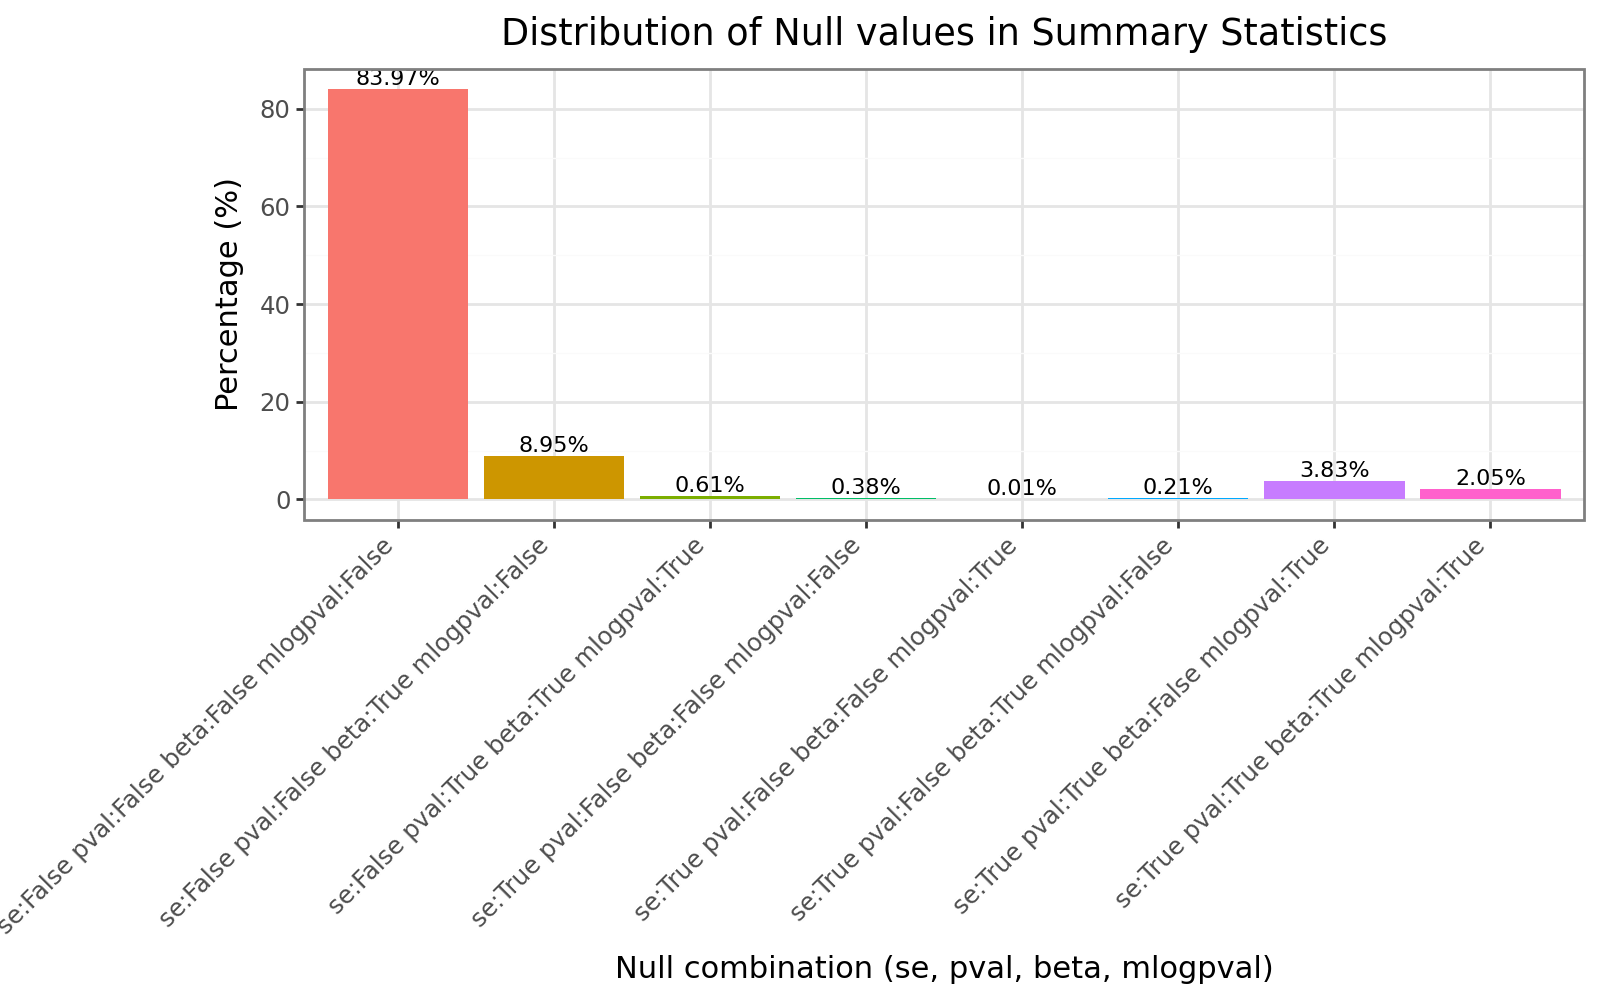

In [84]:
import pandas as pd
from plotnine import *

df = nullable_stats.copy()

# Create a categorical label for each combination
df["pattern"] = df.apply(
    lambda x: f"se:{x.seIsNull} pval:{x.pvalIsNull} beta:{x.betaIsNull} mlogpval:{x.pvalMlogIsNull}",
    axis=1,
)

# Plot: percentage by combination
p = (
    ggplot(df, aes(x="pattern", y="percentage", fill="pattern"))
    + geom_col(show_legend=False)
    + geom_text(
        aes(label=df["percentage"].round(2)),
        va="bottom",
        size=8,
        format_string="{:.2f}%",
    )
    + labs(
        x="Null combination (se, pval, beta, mlogpval)",
        y="Percentage (%)",
        title="Distribution of Null values in Summary Statistics",
    )
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, ha="right"), figure_size=(8, 5))
)

print(p)
p

### Manhattan plot with all variants (except the null p-values)


In [96]:
filtered_sst = (
    sst.filter(f.col("all_inv_var_meta_mlogp").isNotNull())
    .filter(f.col("all_inv_var_meta_beta").isNotNull())
    .filter(f.col("all_inv_var_meta_sebeta").isNotNull())
    .select(
        f.col("#CHR").alias("chromosome"),
        f.col("POS").alias("position"),
        *pvalue_from_neglogpval(f.col("all_inv_var_meta_mlogp")),
    )
    # Add filter on the GWAS significance level
    .filter(
        (f.col("pValueExponent") < -8)
        | ((f.col("pValueExponent") == -8) & (f.col("pValueMantissa") <= 5.0))
    )
)

pd_filtered_sst = filtered_sst.toPandas()

25/10/06 21:31:03 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_1076 !
25/10/06 21:31:03 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_1077 !
25/10/06 21:31:03 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_1064 !
25/10/06 21:31:03 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_1104 !
25/10/06 21:31:03 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_1001 !
25/10/06 21:31:03 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_1154 !
25/10/06 21:31:03 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_1039 !
25/10/06 21:31:03 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_1103 !
25/10/06 21:31:03 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_1177 !
25/10/06 21:31:03 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_1022 !


In [105]:
pd_filtered_sst.shape

(11737127, 4)

/tmp/ipykernel_124517/557398528.py:65: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/mindos/gentropy/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/mindos/gentropy/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


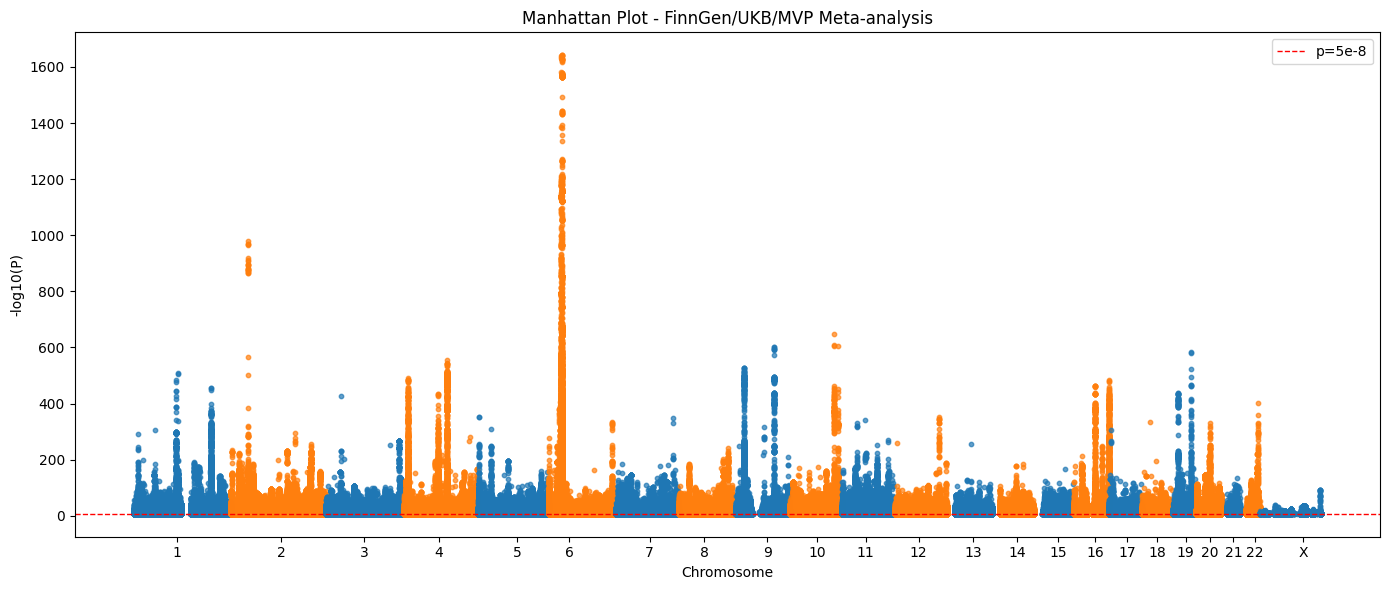

In [116]:
import matplotlib.pyplot as plt
import numpy as np

# Example dataframe
df = pd_filtered_sst.copy()
df.columns = ["chromosome", "position", "pValueMantissa", "pValueExponent"]
df["-log10P"] = -(df["pValueExponent"] + np.log10(df["pValueMantissa"]))

# Convert chromosome to categorical with proper ordering
df["chromosome"] = df["chromosome"].astype(str)
df["chromosome"] = df["chromosome"].replace("23", "X")
chrom_order = [str(i) for i in range(1, 23)] + ["X"]
df["chromosome"] = pd.Categorical(
    df["chromosome"], categories=chrom_order, ordered=True
)
df = df.sort_values(by=["chromosome", "position"])

# Calculate cumulative position for x-axis
df["cumulative_pos"] = 0
chromosome_centers = []
last_pos = 0

for chrom in chrom_order:
    if chrom not in df["chromosome"].values:
        continue
    chrom_df = df[df["chromosome"] == chrom]
    df.loc[df["chromosome"] == chrom, "cumulative_pos"] = (
        chrom_df["position"] + last_pos
    )
    # Store center position for chromosome labels
    chromosome_centers.append((chrom, last_pos + chrom_df["position"].median()))
    last_pos = df[df["chromosome"] == chrom]["cumulative_pos"].max()

# Plot
plt.figure(figsize=(14, 6))
colors = ["#1f77b4", "#ff7f0e"]  # Alternating colors

for i, chrom in enumerate(chrom_order):
    if chrom not in df["chromosome"].values:
        continue
    chrom_df = df[df["chromosome"] == chrom]
    plt.scatter(
        chrom_df["cumulative_pos"],
        chrom_df["-log10P"],
        c=colors[i % 2],
        s=10,
        alpha=0.7,
    )

# Add genome-wide significance line
plt.axhline(y=7.3, color="red", linestyle="--", linewidth=1, label="p=5e-8")

# Set chromosome labels on x-axis
plt.xticks(
    [pos for _, pos in chromosome_centers],
    [str(chrom) for chrom, _ in chromosome_centers],
    rotation=0,
)

plt.xlabel("Chromosome")
plt.ylabel("-log10(P)")
plt.title("Manhattan Plot - FinnGen/UKB/MVP Meta-analysis")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from pyspark.sql import types as t

from gentropy.dataset.summary_statistics import SummaryStatistics

In [ ]:
sumstats = SummaryStatistics(
    _df=sst.filter(f.col("all_inv_var_meta_mlogp").isNotNull())
    .filter(f.col("all_inv_var_meta_beta").isNotNull())
    .filter(f.col("all_inv_var_meta_sebeta").isNotNull())
    .select(
        f.col("studyId"),
        f.concat_ws(
            "_",
            f.col("#CHR"),
            f.col("POS").cast(t.IntegerType()),
            f.col("REF"),
            f.col("ALT"),
        ).alias("variantId"),
        f.when(f.col("#CHR").cast(t.StringType()) == f.lit("23"), f.lit("X"))
        .otherwise(f.col("#CHR").cast(t.StringType()))
        .alias("chromosome"),
        f.col("POS").cast(t.IntegerType()).alias("position"),
        f.col("all_inv_var_meta_beta").alias("beta"),
        f.col("all_inv_var_meta_sebeta").alias("standardError"),
        *pvalue_from_neglogpval(f.col("all_inv_var_meta_mlogp")),
    )
)

In [157]:
sumstats.df.select(f.col("variantId")).distinct().cache().join(
    vd.df, how="inner", on="variantId"
).drop_duplicates(["variantId"]).count()

25/10/06 23:18:50 WARN CacheManager: Asked to cache already cached data.


43076170

In [158]:
sumstats.df.select("variantId").distinct().count()

44572866

In [159]:
type_counts = (
    group_statistics(
        sumstats.df.select(f.col("variantId"))
        .distinct()
        .join(vd.df, how="left", on="variantId")
        .drop_duplicates(["variantId"]),
        "type",
    )
    .cache()
    .toPandas()
)
type_counts

,type,count,%,percentage
0,1.0,40055449,89.87,89.865096
1,3.0,1810795,4.06,4.062550
2,NaN,1496696,3.36,3.357864
3,2.0,1209926,2.71,2.714490


In [160]:
strand_counts = (
    group_statistics(
        sumstats.df.select(f.col("variantId"))
        .distinct()
        .join(vd.df, how="left", on="variantId")
        .drop_duplicates(["variantId"]),
        "strand",
    )
    .cache()
    .toPandas()
)
strand_counts

,strand,count,%,percentage
0,1.0,43076170,96.64,96.642136
1,NaN,1496696,3.36,3.357864


In [161]:
direction_counts = (
    group_statistics(
        sumstats.df.select(f.col("variantId"))
        .distinct()
        .join(vd.df, how="left", on="variantId")
        .drop_duplicates(["variantId"]),
        "direction",
    )
    .cache()
    .toPandas()
)
direction_counts

,direction,count,%,percentage
0,1.0,42571034,95.51,95.508855
1,NaN,1496696,3.36,3.357864
2,-1.0,505136,1.13,1.133281


In [162]:
palindromes = (
    group_statistics(
        sumstats.df.select(f.col("variantId"))
        .distinct()
        .join(vd.df, how="left", on="variantId")
        .drop_duplicates(["variantId"]),
        "isPalindromic",
    )
    .cache()
    .toPandas()
)
palindromes

,isPalindromic,count,%,percentage
0,False,36866233,82.71,82.710035
1,True,6209937,13.93,13.932102
2,None,1496696,3.36,3.357864


In [163]:
all_groups = (
    group_statistics(
        sumstats.df.select(f.col("variantId"))
        .distinct()
        .join(vd.df, how="left", on="variantId")
        .drop_duplicates(["variantId"]),
        ["strand", "direction", "type", "isPalindromic"],
    )
    .cache()
    .toPandas()
)
all_groups

,strand,direction,type,isPalindromic,count,%,percentage
0,1.0,1.0,1.0,False,33845512,75.93,75.932995
1,1.0,1.0,1.0,True,6209937,13.93,13.932102
2,1.0,1.0,3.0,False,1539106,3.45,3.453011
3,NaN,NaN,NaN,None,1496696,3.36,3.357864
4,1.0,1.0,2.0,False,976479,2.19,2.190748
5,1.0,-1.0,3.0,False,271689,0.61,0.609539
6,1.0,-1.0,2.0,False,233447,0.52,0.523742


In [ ]:
found_in_gnomad_vi = (
    group_statistics(
        sumstats.df.select(f.col("variantId"))
        .distinct()
        .join(vd.df, how="left", on="variantId")
        .select("variantId", "originalVariantId")
        .distinct()
        .select(
            f.when(f.col("originalVariantId").isNotNull(), True)
            .otherwise(False)
            .alias("foundInVariantDirection")
        ),
        "foundInVariantDirection",
    )
    .cache()
    .toPandas()
)

found_in_gnomad_vi

,foundInVariantDirection,count,%,percentage
0,True,44083486,96.72,96.716345
1,False,1496696,3.28,3.283655


25/10/06 23:27:12 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 637 for reason Executor for container container_1759739267367_0023_01_000689 exited because of a YARN event (e.g., preemption) and not because of an error in the running job.
25/10/06 23:27:12 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 633 for reason Executor for container container_1759739267367_0023_01_000685 exited because of a YARN event (e.g., preemption) and not because of an error in the running job.
25/10/06 23:27:12 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 649 for reason Executor for container container_1759739267367_0023_01_000701 exited because of a YARN event (e.g., preemption) and not because of an error in the running job.
25/10/06 23:27:12 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 639 for reason Executor for container container_17597392673